#### 필요한 라이브러리 import

In [2]:
import pandas as pd
import numpy as np
import random 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.keras.models import load_model
import matplotlib
import matplotlib.pyplot as plt

#### 데이터 전처리
1. data의 column 이름을 적절하게 변경
2. 결측치 값의 존재유무를 확인해 존재한다면 제거
3. 연령 별로 정렬된 데이터를 학습을 위해 랜덤하게 shuffle
4. 연령 별로 grouping된 데이터를 연령대 데이터로 변경(ex. 연령(그룹)이 1인 경우 20대로 변경)

In [ ]:
# raw data를 csv파일 형태로 읽어와 data에 저장
data = pd.read_csv("국가건강검진_혈압혈당데이터_원본.csv", encoding = 'utf-8')
data.head()

In [ ]:
data.columns

In [ ]:
# data의 column 이름을 적절하게 변경
data.rename(columns = {"SEX" : "성별", "BTH_G" : "연령(그룹)", "SBP" : "수축기혈압",
                      "DBP" : "이완기혈압", "FBS" : "공복기혈당", "DIS" : "고혈압/당뇨병 진료여부",
                      "BMI" : "체질량지수"}, inplace = True)

In [ ]:
data.head()
#### 성별 (1 : 남자, 2: 여자)
#### 고혈압/당뇨병 진료여부 (1 : 고혈압/당뇨병 진료내역 있음, 2 : 고혈압 진료내역 있음, 3 : 당뇨 진료내역 있음, 4 : 진료내역 없음)

In [ ]:
data["연령대"] = 0
data.head()

In [ ]:
# na값 확인
data.isna().sum()

In [ ]:
len(data)

In [ ]:
# data shuffle
data = data.sample(frac=1).reset_index(drop = True)
data.head(10)

In [ ]:
# data의 연령을 읽어와 20~70대의 연령대 형태로 저장
for i in range(len(data)) :
    if (data["연령(그룹)"][i] in [1, 2, 3, 4]) :
        data["연령대"][i] = 20
    elif (data["연령(그룹)"][i] in [5, 6, 7, 8, 9]) :
        data["연령대"][i] = 30
    elif (data["연령(그룹)"][i] in [10, 11, 12, 13, 14]) :
        data["연령대"][i] = 40
    elif (data["연령(그룹)"][i] in [15, 16, 17, 18, 19]) :
        data["연령대"][i] = 50
    elif (data["연령(그룹)"][i] in [20, 21, 22, 23, 24]) :
        data["연령대"][i] = 60
    else :
        data["연령대"][i] = 70

In [ ]:
del data["연령(그룹)"]
data

In [ ]:
# 전처리된 데이터를 저장
data.to_csv("혈압혈당_데이터_가공.csv", index = False, encoding = 'cp949')

#### 전처리된 데이터를 바탕으로 모델 구현

In [3]:
# 전처리된 데이터를 csv형태로 읽어와서 data에 저장
data = pd.read_csv("혈압혈당_데이터_가공.csv", encoding = 'cp949')

In [4]:
data

,성별,수축기혈압,이완기혈압,공복기혈당,고혈압/당뇨병 진료여부,체질량지수,연령대
0,2,120,90,79,2,21.0,40
1,2,119,75,108,1,24.0,60
2,1,122,86,102,4,24.4,40
3,1,120,75,89,4,24.8,30
4,2,101,66,79,4,22.9,30
...,...,...,...,...,...,...,...
999995,2,120,70,92,2,22.2,70
999996,1,130,70,76,3,21.0,60
999997,1,121,66,103,4,24.9,30
999998,1,137,72,82,4,27.9,50


In [5]:
# data의 열 순서 변경
data = data[['성별', '수축기혈압', '이완기혈압', '공복기혈당', '체질량지수', '연령대', '고혈압/당뇨병 진료여부']]
data

,성별,수축기혈압,이완기혈압,공복기혈당,체질량지수,연령대,고혈압/당뇨병 진료여부
0,2,120,90,79,21.0,40,2
1,2,119,75,108,24.0,60,1
2,1,122,86,102,24.4,40,4
3,1,120,75,89,24.8,30,4
4,2,101,66,79,22.9,30,4
...,...,...,...,...,...,...,...
999995,2,120,70,92,22.2,70,2
999996,1,130,70,76,21.0,60,3
999997,1,121,66,103,24.9,30,4
999998,1,137,72,82,27.9,50,4


In [6]:
# 데이터의 통계 확인
data.describe()

,성별,수축기혈압,이완기혈압,공복기혈당,체질량지수,연령대,고혈압/당뇨병 진료여부
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.489773,121.871763,75.787874,98.864428,23.804029,43.919420,3.471040
std,0.499896,14.561706,9.793411,22.981300,3.297287,14.356802,0.946151
min,1.000000,82.000000,50.000000,60.000000,14.800000,20.000000,1.000000
25%,1.000000,110.000000,70.000000,87.000000,21.500000,30.000000,3.000000
50%,1.000000,120.000000,76.000000,94.000000,23.600000,40.000000,4.000000
75%,2.000000,130.000000,80.000000,104.000000,25.800000,50.000000,4.000000
max,2.000000,190.000000,120.000000,358.000000,40.300000,70.000000,4.000000


In [7]:
# 고혈압/당뇨병 진료여부 별 비율
grouped = data.groupby(data["고혈압/당뇨병 진료여부"]).size()/len(data)
grouped

고혈압/당뇨병 진료여부
1    0.053398
2    0.162826
3    0.043114
4    0.740662
dtype: float64

In [8]:
print(max(data["수축기혈압"]))
print(max(data["이완기혈압"]))
print(max(data["공복기혈당"]))
print(max(data["체질량지수"]))
print(max(data["연령대"]))

190
120
358
40.3
70


In [9]:
# 0-1 normalization(학습 속도를 높이기 위함) --> 각 데이터를 최댓값으로 나눠줌
data["수축기혈압"] /= 190
data["이완기혈압"] /= 120
data["공복기혈당"] /= 358
data["체질량지수"] /= 40.3
data["연령대"] /= 70

In [10]:
# one-hot encoding
dclass = {1:[1,0,0,0], 2:[0,1,0,0], 3:[0,0,1,0], 4:[0,0,0,1]}

# 1000000 * 4 다차원 벡터 생성
Y = np.empty((1000000,4)) 

# 고혈압/당뇨병 진료여부가 1이면 [1,0,0,0]과 같이 할당
for i, v in enumerate(data["고혈압/당뇨병 진료여부"]):
    Y[i] = dclass[v] 
X = data.iloc[:, 0:6]

In [11]:
# training dataset(80만 개)
X_train, Y_train = X[0:800000], Y[0:800000]

# test dataset(20만 개)
X_test, Y_test = X[800000:], Y[800000:]

In [12]:
# 6개의 특징(feature)를 가진 800000개 데이터
print(X_train.shape)
# 4개의 특징(feature)를 가진 800000개 데이터
print(Y_train.shape)
print(Y_train[0])

(800000, 6)
(800000, 4)
[0. 1. 0. 0.]


In [13]:
X_train.head()

,성별,수축기혈압,이완기혈압,공복기혈당,체질량지수,연령대
0,2,0.631579,0.750000,0.220670,0.521092,0.571429
1,2,0.626316,0.625000,0.301676,0.595533,0.857143
2,1,0.642105,0.716667,0.284916,0.605459,0.571429
3,1,0.631579,0.625000,0.248603,0.615385,0.428571
4,2,0.531579,0.550000,0.220670,0.568238,0.428571


In [14]:
class MLP :
    def __init__(self, given_X_train, given_Y_train,
                 given_X_test, given_Y_test,
                 given_num_layer_1, given_num_layer_2) :
        self.X_train = given_X_train
        self.Y_train = given_Y_train
        self.X_test = given_X_test
        self.Y_test = given_Y_test
        self.model = tf.keras.Sequential()
        self.num_class = 4 # class label 수
        self.num_input = 6 # 입력값의 차원
        self.num_layer_1 = given_num_layer_1 
        self.num_layer_2 = given_num_layer_2
        self.drop_out = 0.1 # drop-out rate
        self.hidden_ftn = 'relu' # 은닉층 활성함수
        self.output_ftn = 'softmax' # 출력층 활성함수
        self.loss_ftn = 'categorical_crossentropy' # 손실함수
        self.optimizer = 'adam' # 최적화 기법
        self.metrics = 'accuracy' 
        self.batch_size = 100000 
        self.epochs = 1000
        self.validation_split = 0.2
        self.score = list()
        self.hist = tf.keras.callbacks.History()
    
    # 모델 생성 및 구현
    def generate_model(self) : 
        # 첫 번째 은닉층
        self.model.add(layers.Dense(self.num_layer_1, input_shape=(self.num_input,))) 
        self.model.add(layers.Activation(self.hidden_ftn))  
        self.model.add(layers.Dropout(self.drop_out))        

        # 두 번째 은닉층
        self.model.add(layers.Dense(self.num_layer_2))            
        self.model.add(layers.Activation(self.hidden_ftn))
        self.model.add(layers.Dropout(self.drop_out))

        # 출력층
        self.model.add(layers.Dense(self.num_class))
        self.model.add(layers.Activation(self.output_ftn))
        
        self.model.compile(loss = self.loss_ftn, 
                      optimizer = self.optimizer, 
                      metrics = [self.metrics]) 
    
    # 모델 학습
    def train_model(self) :
        self.hist = self.model.fit(self.X_train, self.Y_train,batch_size = self.batch_size, 
                       epochs = self.epochs, # training epoch         
                       validation_split = self.validation_split, # validation split
                       # validation loss가 최저인 시점에서 epoch이 patience만큼 진행되는 동안 loss가 개선되지 않으면 학습 종료
                       callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15)], # early stopping
                       verbose = 1)
    
    # 모델 평가
    def evaluate_model(self) :
        self.score = self.model.evaluate(self.X_test, self.Y_test)
        return self.score
    
    def show_train_val_acc(self) :
        fig, loss_ax = plt.subplots()
        acc_ax = loss_ax.twinx()

        loss_ax.plot(self.hist.history['loss'], 'y', label = 'train loss')
        loss_ax.plot(self.hist.history['val_loss'], 'r', label = 'val loss')

        acc_ax.plot(self.hist.history['accuracy'], 'b', label = 'train acc')
        acc_ax.plot(self.hist.history['val_accuracy'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuray')

        loss_ax.legend(loc='upper left')
        acc_ax.legend(loc='lower left')
        
        plt.show()
    
    def show_model_summary(self) :
        print(self.model.summary())
    
    # 학습된 모델 저장
    def save_model(self) :
        self.model.save("dnn_term_project.h5")
        print("Model saved!")
        
    def set_hidden_ftn(self, given_hidden_ftn) :
        self.hidden_ftn = given_hidden_ftn
        
    def set_output_ftn(self, given_output_ftn, given_loss_ftn) :
        self.output_ftn = given_output_ftn
        self.loss_ftn = given_loss_ftn
        
    def set_dropout(self, given_dropout) :
        self.dropout = given_dropout
    
    def set_optimizer(self, given_optimizer) :
        self.optimizer = given_optimizer
    
    def set_batchsize(self, given_batch_size) :
        self.batch_size = given_batch_size
        
    def set_epochs(self, given_epochs) :
        self,epochs = given_epochs
        
    def set_validation_split(self, given_validation_split) :
        self.validation_split = given_validation_split
        
    def get_all(self) :
        print("은닉층 활성함수 : ", self.hidden_ftn) 
        print("출력층 활성함수: " , self.output_ftn) 
        print("손실함수 : ", self.loss_ftn) 
        print("최적화 기법 : " ,self.optimizer)
    
    def get_dropout(self) :
        return self.dropout
    
    def get_optimizer(self) :
        return self.optimizer
    
    def get_epochs(self) :
        return self.epochs
    
    def get_validation_split(self) :
        return self.validation_split

In [15]:
my_model = MLP(X_train, Y_train, X_test, Y_test, 32, 32)
my_model.generate_model()
my_model.train_model()
score = my_model.evaluate_model()
print('test_loss: ', score[0])
print('test_acc: ', score[1])

Epoch 1/1000
7/7 [==============================] - 3s 275ms/step - loss: 1.2730 - accuracy: 0.5613 - val_loss: 1.1979 - val_accuracy: 0.7413
Epoch 2/1000
7/7 [==============================] - 1s 178ms/step - loss: 1.1708 - accuracy: 0.7105 - val_loss: 1.1118 - val_accuracy: 0.7413
Epoch 3/1000
7/7 [==============================] - 1s 196ms/step - loss: 1.0858 - accuracy: 0.7374 - val_loss: 1.0329 - val_accuracy: 0.7413
Epoch 4/1000
7/7 [==============================] - 1s 170ms/step - loss: 1.0105 - accuracy: 0.7404 - val_loss: 0.9642 - val_accuracy: 0.7413
Epoch 5/1000
7/7 [==============================] - 1s 157ms/step - loss: 0.9485 - accuracy: 0.7407 - val_loss: 0.9085 - val_accuracy: 0.7413
Epoch 6/1000
7/7 [==============================] - 1s 194ms/step - loss: 0.9043 - accuracy: 0.7407 - val_loss: 0.8733 - val_accuracy: 0.7413
Epoch 7/1000
7/7 [==============================] - 1s 184ms/step - loss: 0.8807 - accuracy: 0.7407 - val_loss: 0.8563 - val_accuracy: 0.7413
Epoch 

7/7 [==============================] - 1s 214ms/step - loss: 0.5897 - accuracy: 0.7664 - val_loss: 0.5728 - val_accuracy: 0.7735
Epoch 116/1000
7/7 [==============================] - 1s 207ms/step - loss: 0.5889 - accuracy: 0.7667 - val_loss: 0.5727 - val_accuracy: 0.7737
Epoch 117/1000
7/7 [==============================] - 1s 204ms/step - loss: 0.5886 - accuracy: 0.7671 - val_loss: 0.5727 - val_accuracy: 0.7734
Epoch 118/1000
7/7 [==============================] - 1s 174ms/step - loss: 0.5887 - accuracy: 0.7669 - val_loss: 0.5725 - val_accuracy: 0.7737
Epoch 119/1000
7/7 [==============================] - 2s 239ms/step - loss: 0.5884 - accuracy: 0.7664 - val_loss: 0.5723 - val_accuracy: 0.7741
Epoch 120/1000
7/7 [==============================] - 1s 168ms/step - loss: 0.5879 - accuracy: 0.7668 - val_loss: 0.5722 - val_accuracy: 0.7736
Epoch 121/1000
7/7 [==============================] - 1s 160ms/step - loss: 0.5883 - accuracy: 0.7667 - val_loss: 0.5722 - val_accuracy: 0.7738
Epoch 1

Epoch 172/1000
7/7 [==============================] - 1s 167ms/step - loss: 0.5814 - accuracy: 0.7695 - val_loss: 0.5693 - val_accuracy: 0.7743
Epoch 173/1000
7/7 [==============================] - 1s 168ms/step - loss: 0.5818 - accuracy: 0.7691 - val_loss: 0.5693 - val_accuracy: 0.7742
Epoch 174/1000
7/7 [==============================] - 1s 162ms/step - loss: 0.5815 - accuracy: 0.7693 - val_loss: 0.5692 - val_accuracy: 0.7744
Epoch 175/1000
7/7 [==============================] - 1s 169ms/step - loss: 0.5819 - accuracy: 0.7691 - val_loss: 0.5692 - val_accuracy: 0.7743
Epoch 176/1000
7/7 [==============================] - 1s 152ms/step - loss: 0.5813 - accuracy: 0.7692 - val_loss: 0.5693 - val_accuracy: 0.7742
Epoch 177/1000
7/7 [==============================] - 1s 149ms/step - loss: 0.5812 - accuracy: 0.7698 - val_loss: 0.5694 - val_accuracy: 0.7742
Epoch 178/1000
7/7 [==============================] - 1s 168ms/step - loss: 0.5813 - accuracy: 0.7694 - val_loss: 0.5694 - val_accuracy:

Epoch 229/1000
7/7 [==============================] - 1s 177ms/step - loss: 0.5783 - accuracy: 0.7706 - val_loss: 0.5676 - val_accuracy: 0.7745
Epoch 230/1000
7/7 [==============================] - 1s 153ms/step - loss: 0.5784 - accuracy: 0.7707 - val_loss: 0.5675 - val_accuracy: 0.7748
Epoch 231/1000
7/7 [==============================] - 1s 156ms/step - loss: 0.5783 - accuracy: 0.7706 - val_loss: 0.5676 - val_accuracy: 0.7745
Epoch 232/1000
7/7 [==============================] - 1s 174ms/step - loss: 0.5779 - accuracy: 0.7705 - val_loss: 0.5676 - val_accuracy: 0.7746
Epoch 233/1000
7/7 [==============================] - 1s 170ms/step - loss: 0.5780 - accuracy: 0.7708 - val_loss: 0.5674 - val_accuracy: 0.7749
Epoch 234/1000
7/7 [==============================] - 1s 180ms/step - loss: 0.5779 - accuracy: 0.7711 - val_loss: 0.5673 - val_accuracy: 0.7749
Epoch 235/1000
7/7 [==============================] - 1s 174ms/step - loss: 0.5783 - accuracy: 0.7710 - val_loss: 0.5673 - val_accuracy:

Epoch 286/1000
7/7 [==============================] - 1s 185ms/step - loss: 0.5762 - accuracy: 0.7718 - val_loss: 0.5665 - val_accuracy: 0.7753
Epoch 287/1000
7/7 [==============================] - 1s 160ms/step - loss: 0.5762 - accuracy: 0.7715 - val_loss: 0.5666 - val_accuracy: 0.7750
Epoch 288/1000
7/7 [==============================] - 1s 154ms/step - loss: 0.5764 - accuracy: 0.7717 - val_loss: 0.5667 - val_accuracy: 0.7752
Epoch 289/1000
7/7 [==============================] - 1s 171ms/step - loss: 0.5762 - accuracy: 0.7717 - val_loss: 0.5666 - val_accuracy: 0.7753
Epoch 290/1000
7/7 [==============================] - 1s 150ms/step - loss: 0.5767 - accuracy: 0.7717 - val_loss: 0.5667 - val_accuracy: 0.7749
Epoch 291/1000
7/7 [==============================] - 1s 159ms/step - loss: 0.5761 - accuracy: 0.7714 - val_loss: 0.5669 - val_accuracy: 0.7746
Epoch 292/1000
7/7 [==============================] - 1s 179ms/step - loss: 0.5762 - accuracy: 0.7718 - val_loss: 0.5668 - val_accuracy:

In [16]:
my_model.show_model_summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 1

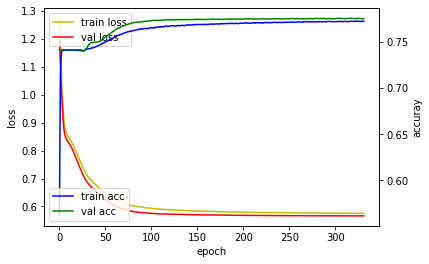

In [17]:
my_model.show_train_val_acc()

In [18]:
my_model.get_all()

은닉층 활성함수 :  relu
출력층 활성함수:  softmax
손실함수 :  categorical_crossentropy
최적화 기법 :  adam


In [19]:
my_model.save_model()

Model saved!


In [20]:
# 저장된 모델 loading
loaded_model = load_model("dnn_term_project.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1

In [22]:
# 새로운 샘플의 클래스 예측하기
X_new = [2, 160, 105, 98, 25, 40]
X_new_scaled = [2, 160/190, 105/120, 148/358, 25/40.3, 40/70]
print(X_new)
print(X_new_scaled)
Y_prob = loaded_model.predict([X_new_scaled])
print(Y_prob)
Y_pred = Y_prob.argmax()
print(Y_pred + 1)

# 1 : 고혈압/당뇨병 진료내역 있음, 2 : 고혈압 진료내역 있음, 3 : 당뇨 진료내역 있음, 4 : 진료내역 없음
if(Y_pred + 1 == 1) :
    print("고혈압/당뇨병 진료내역 있음")
elif(Y_pred + 1 == 2) :
    print("고혈압 진료내역 있음")
elif(Y_pred + 1 == 3) :
    print("당뇨 진료내역 있음")
else :
    print("진료내역 없음")

[2, 160, 105, 98, 25, 40]
[2, 0.8421052631578947, 0.875, 0.4134078212290503, 0.620347394540943, 0.5714285714285714]
[[0.33020613 0.22143085 0.19667351 0.25168955]]
1
고혈압/당뇨병 진료내역 있음


#### 결론
 학습된 모델의 정확도는 약 77.5%로 예상보다 다소 낮았다. 그 이유는 현재 가설은 성별, 연령대, 수축기혈압, 이완기혈압, 공복기혈당, 체질량지수만을 활용해 고혈압과 당뇨병의 진료여부를 예측하는 것인데, 실제로는 더 많은 요인이 고혈압과 당뇨병의 원인으로 작용하기 때문이다. 하지만, 위의 예측과 같이 혈압이 160/105, 공복기혈당이 148로 상당히 높은 경우에 대해서는 고혈압 및 당뇨병의 진료 내역이 있을 것이라는 유의미한 결과를 도출한다. 또한, 현재 가진 데이터 중에서 진료내역이 없는 환자가 전체 데이터 중에서 약 74% 이상을 차지하는 것을 볼 수 있는데, 고혈압 및 당뇨병 진료를 받은 환자들의 데이터에 비해 월등히 많은 것으로 판단된다. 이런 데이터의 불균형이 생기기 때문에 학습이 생각보다 잘 진행되지 않는 어려움은 있었으나, 모든 데이터에 대해 진료 내역이 없다고 판단하는 모델의 경우에 74% 정도의 정확도가 측정이 되지만, 현재 정확도는 약 77.5%이므로 모델 성능이 비교적 높다고 볼 수 있다. 

#### 참고문헌
기계학습 by 오일석